In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sdf import *

@sdf3
def gyroid(w = 3.14159, t=0):
    def f(p):
        q = w*p
        x, y, z = (q[:, i] for i in range(3))
        return (np.cos(x)*np.sin(y) + np.cos(y)*np.sin(z) + np.cos(z)*np.sin(x) - t)
    return f

from sdf.mesh import _cartesian_product, _estimate_bounds
import igl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def sdf_at_z(f, bounds=[(-1,-1,-1),(1,1,1)], z_level=0, nums=100, offset=0.3):
    
    (x0, y0, z0), (x1, y1, z1) = bounds

    X = np.linspace(x0-offset, x1+offset, nums)
    Y = np.linspace(y0-offset, y1+offset, nums)
    Z = np.array([z_level])

    P = _cartesian_product(X, Y, Z)
    df = pd.DataFrame(P, columns = ['X', 'Y', 'Z'])
    
    mode = 'sdf' if isinstance(f, SDF3) else 'igl'
    if mode == 'igl':
        v, f = igl.read_triangle_mesh(f)
        df['sdf'] = -(igl.signed_distance(P, v, f, return_normals=False)[0])
    else:
        df['sdf'] = -f(P)
    return df

def cal_2d_gradient(df, key='sdf', nums=100, step=.01):
    lvl = df[key].to_numpy().reshape((nums, nums))
    gx = np.array(np.gradient(lvl, step, step, axis=0))
    gy = np.array(np.gradient(lvl, step, step, axis=1))
    df['gradient_'+key] = np.norm()
    

def plot_df_heatmap(df, x='X', y='Y', z='sdf'):
    pv_df = df.pivot(x, y, z)
    c = sns.heatmap(pv_df, cmap='coolwarm', center=0)
    c.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
    c.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x:,.2f}'))
    plt.show()

In [2]:
# Generate with skimage.measure.marching_cubes
f = sphere(0.5)
points = f.generate(step=0.01, verbose=True, method=1)
write_binary_stl('sphere_1.stl', points)

min -0.565721, -0.565721, -0.565721
max 0.565722, 0.565722, 0.565722
step 0.01, 0.01, 0.01

94272 triangles in 0.146001 seconds


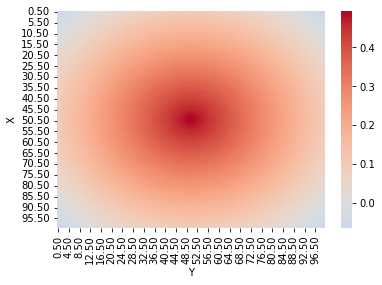

In [3]:
bounds=[(-.1,-.1,-.1),(.1,.1,.1)]
df1 = sdf_at_z(f, bounds)
plot_df_heatmap(df1)

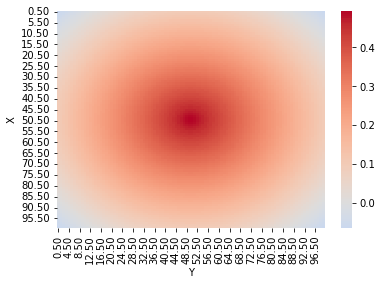

In [4]:
df2 = sdf_at_z('sphere_1.stl', bounds)
plot_df_heatmap(df2)

In [17]:
df1['diff'] = df1['sdf'] - df2['sdf']

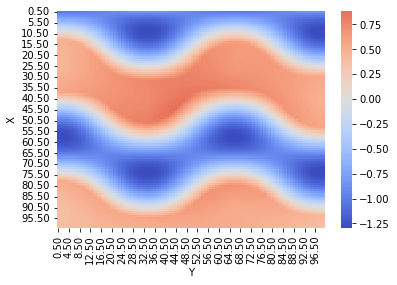

In [18]:
plot_df_heatmap(df1, z='diff')

In [ ]:
lvl = df1['X'].to_numpy().reshape((100,100,))
gx = np.array(np.gradient(lvl, axis=0))
gy = np.array(np.gradient(lvl, axis=1))
